In [1]:
using Revise, Statistics, LaTeXStrings, DSP, StatsBase
using Formatting, MAT, ControlSystems, FFTW
using CairoMakie, Makie
using ColorSchemes
import ColorSchemes: nord, tab10, Dark2_8

printx(x,N) = sprintf1("%.$(N)f",x)


# fg = :black  # nord[5]
# gg = :grey   # nord[3]
fg = nord[5]
gg = nord[3]
bg = :transparent

cscheme = Dark2_8

set_theme!(Theme(
    fontsize = 20,
    palette = ( color = cscheme,),
    markerstrokewidth=0.1,
    Axis = (
        backgroundcolor = bg,
        xtickcolor = fg, ytickcolor = fg,
        xgridcolor = gg, ygridcolor = gg,
        xlabelcolor = fg, ylabelcolor = fg,
        xticklabelcolor = fg, yticklabelcolor = fg,
        topspinecolor = fg, bottomspinecolor = fg,
        leftspinecolor = fg, rightspinecolor = fg,
        titlecolor = fg,
    ),
    Legend = (
        bgcolor = bg,
        labelcolor = fg, titlecolor = fg,
        framevisible = false, margin=(0,0,0,0)
    )
))

In [2]:
function covpred(x, p, r)
    N = length(x)
    X = zeros(N+p, p+1)
    for i=1:p+1
        X[i:i+N-1,i] = x
    end
    b = [x[1]; zeros(N+p-1)]
    a = X \ b
    err = mean((x - filt(1.0, a, [1; zeros(N-1)])).^2)
    return [a, err]
end

function corrpred(x, p, r)
    p = p-1
    N = length(x)
    X = zeros(N+p, p+1)
    for i=1:p+1
        X[i:i+N-1,i] = x
    end
    X = X[p+1:N-1,:] 
    b = x[p+2:N]
    a = [ 1; -X \ b ]
    err = mean((x - filt(1.0, a, [1; zeros(N-1)])).^2)
    return [a, err]
end

corrpred (generic function with 1 method)

In [3]:
x = filt(1.0, [1,0.2,0.3], [1; zeros(100)])
@show covpred(x, 2, 0);
@show corrpred(x, 2, 0);

covpred(x, 2, 0) = Any[[1.0, 0.20000000000000004, 0.3], 4.523690588545417e-35]
corrpred(x, 2, 0) = Any[[1.0, 0.19999999999999998, 0.29999999999999993], 5.611008013959383e-35]


In [4]:
ARdata = matread("ARdata.mat")
x1 = ARdata["y1"]
x2 = ARdata["y2"]
x3 = ARdata["y3"]
a1 = vec(Real.(ARdata["a1"]))

4-element Vector{Float64}:
  1.0
 -1.9099026535611552
  1.3989016800967666
 -0.4949

P = tf([1.0], a1) = TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
                             1.0
-------------------------------------------------------------
1.0s^3 - 1.9099026535611552s^2 + 1.3989016800967666s - 0.4949

Continuous-time transfer function model


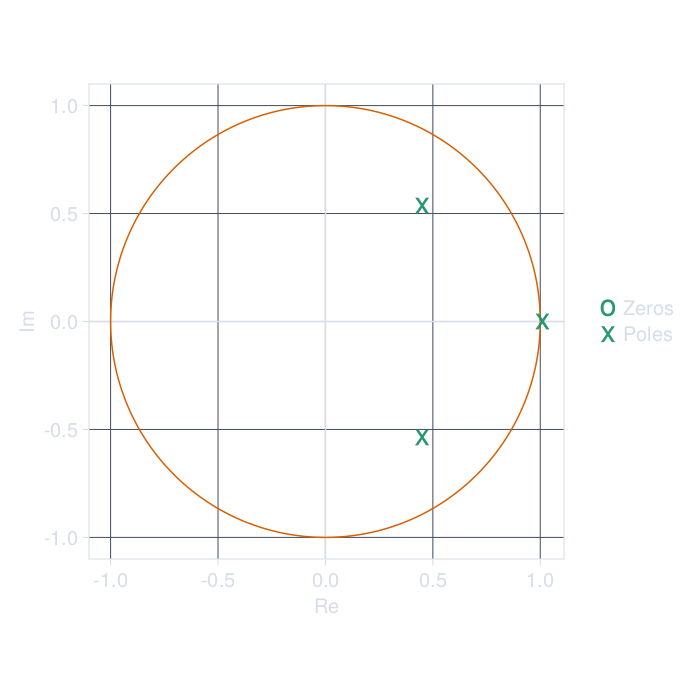

In [5]:
@show P = tf([1.0], a1)

function ucircle!(ax::Axis; color=cscheme[1], zero_splines=true)
    if zero_splines
        vlines!(ax, 0, color=fg)
        hlines!(ax, 0, color=fg)
    end
    unit_circle = exp.(1im*(0:0.01:2π))
    lines!(ax, real(unit_circle), imag(unit_circle), color=cscheme[2])
end

function zplane!(ax::Axis, sys::LTISystem; color=cscheme[1])
    z = tzeros(sys)
    p = poles(sys)
    return [
        scatter!(ax, real(z), imag(z), marker='o', color=color, markersize=30),
        scatter!(ax, real(p), imag(p), marker='x', color=color, markersize=30)
    ]
end

F = Figure(backgroundcolor=bg, resolution=(700,700))
ax = Axis(F[1,1], aspect=AxisAspect(1), xlabel="Re", ylabel="Im")
ucircle!(ax)
sc_z, sc_p = zplane!(ax, P)
Legend(F[1,2], [sc_z, sc_p], ["Zeros", "Poles"])
F

(a1_corr, err1_corr) = corrpred(x1, 3, 1) = Any[[1.0, -1.909902653561155, 1.3989016800967657, -0.4948999999999996], 8.898202321888327]
(a1_cov, err1_cov) = covpred(x1, 3, 1) = Any[[0.10568721304388386, -0.11759779190160628, 0.013653657976077474, 0.0006481970741796513], 10.090071046333684]


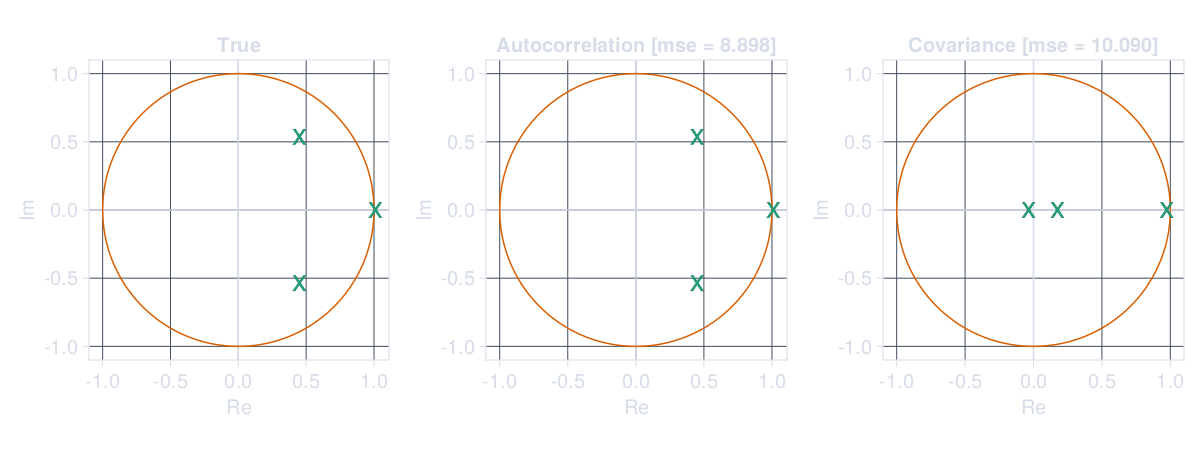

In [6]:
@show a1_corr, err1_corr = corrpred(x1, 3, 1)
@show a1_cov, err1_cov   = covpred(x1, 3, 1)

F = Figure(backgroundcolor=bg, resolution=(1200,450))
ax1 = Axis(F[1,1], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="True")
ax2 = Axis(F[1,2], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="Autocorrelation [mse = $(printx(err1_corr, 3))]")
ax3 = Axis(F[1,3], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="Covariance [mse = $(printx(err1_cov, 3))]")
ucircle!(ax1); zplane!(ax1, P)
ucircle!(ax2); zplane!(ax2, tf([1.0], a1_corr))
ucircle!(ax3); zplane!(ax3, tf([1.0], a1_cov))
F

(a2_corr, err2_corr) = corrpred(x2, 3, 1) = Any[[1.0, -1.9185313001257398, 1.3425206524308066, -0.38761773960672535], 121.81561011332171]
(a2_cov, err2_cov) = covpred(x2, 3, 1) = Any[[0.09935755929661591, -0.13686690986288758, 0.045705897594238085, 0.0015302437101507897], 179.61216431845725]


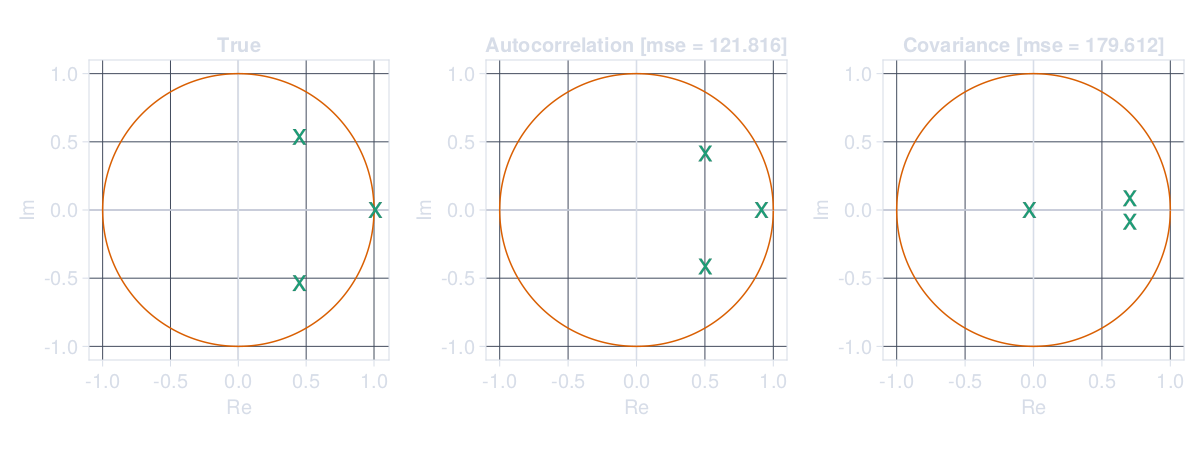

In [7]:
@show a2_corr, err2_corr = corrpred(x2, 3, 1)
@show a2_cov, err2_cov   = covpred(x2, 3, 1)

F = Figure(backgroundcolor=bg, resolution=(1200,450))
ax1 = Axis(F[1,1], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="True")
ax2 = Axis(F[1,2], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="Autocorrelation [mse = $(printx(err2_corr, 3))]")
ax3 = Axis(F[1,3], xlabel="Re", ylabel="Im", aspect=AxisAspect(1), title="Covariance [mse = $(printx(err2_cov, 3))]")
ucircle!(ax1); zplane!(ax1, P)
ucircle!(ax2); zplane!(ax2, tf([1.0], a2_corr))
ucircle!(ax3); zplane!(ax3, tf([1.0], a2_cov))
F

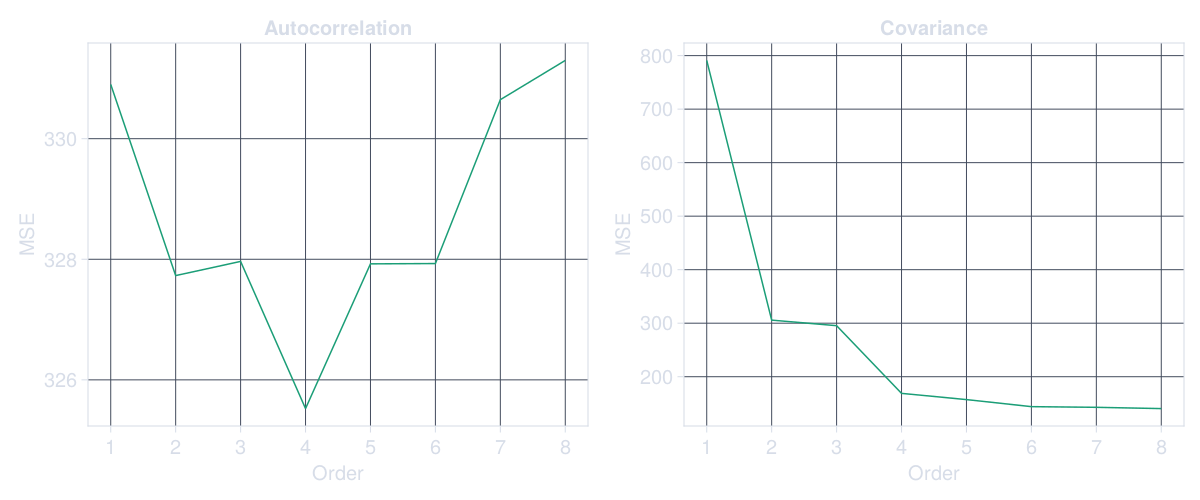

In [8]:
orders = 1:8

corr_errs = zeros(length(orders))
cov_errs = zeros(length(orders))
for (i,o) in enumerate(orders)
    _, corr_errs[i] = corrpred(x3, o, 1)
    _, cov_errs[i] = covpred(x3, o, 1)
end

F = Figure(backgroundcolor=bg, resolution=(1200, 500))
ax1 = Axis(F[1,1], xlabel="Order", ylabel="MSE", title="Autocorrelation", xticks=orders)
ax2 = Axis(F[1,2], xlabel="Order", ylabel="MSE", title="Covariance", xticks=orders)
lines!(ax1, orders, corr_errs)
lines!(ax2, orders, cov_errs)
F

# Ex. 1.2

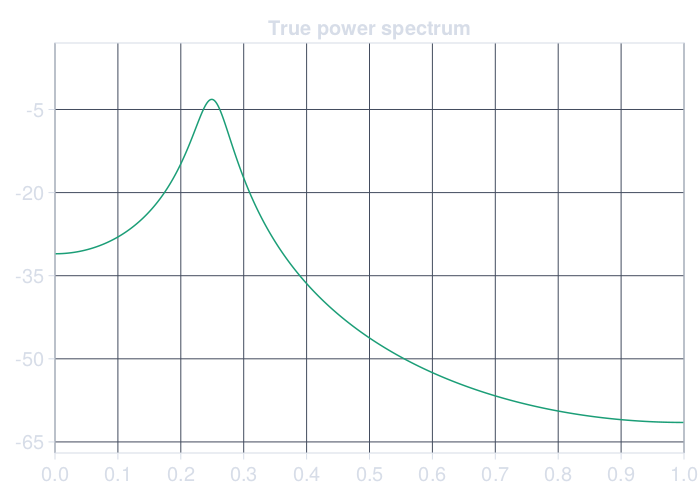

In [35]:
b = 5
a = [ 1.0, -1.3, 0.845 ]

N = 6000
h = filt(b, a, [1; zeros(N-1)])

H = fftshift(fft(h))
H = H[end÷2:end]
P_h = abs.(H.^2)/(N÷2)

F = Figure(backgroundcolor=bg, resolution=(700,500))
ax = Axis(F[1,1], title="True power spectrum", xticks=0:0.1:1, yticks=-65:15:5)
lines!(ax, range(0,1,N÷2+1), amp2db.(P_h))
xlims!(0,1)
ylims!(-67, 7)
F

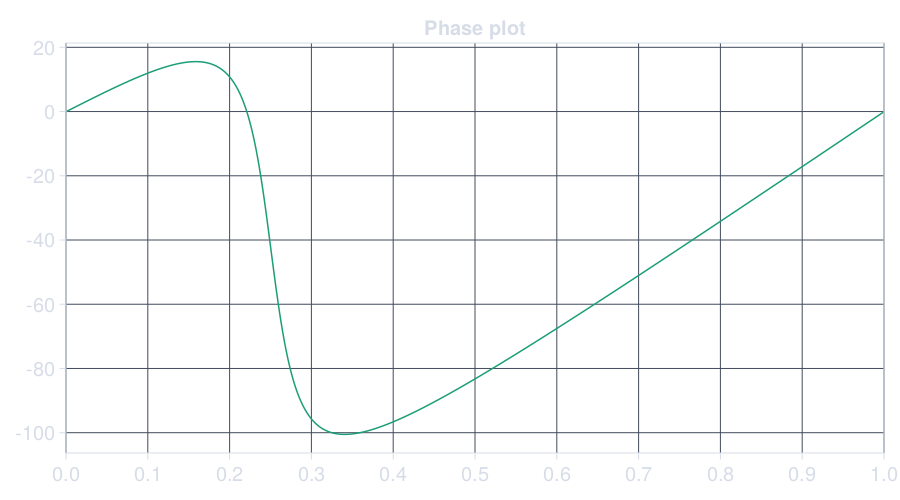

In [21]:
F = Figure(backgroundcolor=bg, resolution=(900,500))
ax = Axis(F[1,1], title="Phase plot", xticks=0:0.1:1, yticks=-120:20:20)
xlims!(0,1)
lines!(ax, range(0,1,N÷2+1), rad2deg.(atan.(imag(H), real(H))))
F

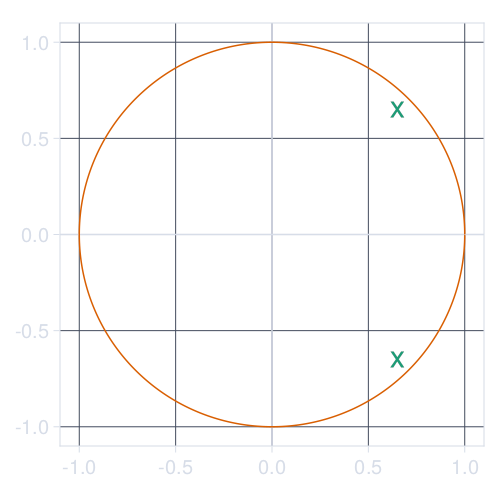

In [ ]:
F = Figure(backgroundcolor=bg, resolution=(700,400))
ax = Axis(F[1,1], aspect=AxisAspect(1))
ucircle!(ax)
zplane!(ax, tf(b, a))
F